# Benchmark the Anderson solver to other nonlinear optimization methods

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
import logging
import cPickle as pickle
from datetime import datetime
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [2]:
"""Set system dimensions and constants"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.014*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=4.0, eps_wire=17.7, 
                                    gamma=hbar**2/(2*meff*akwant**2), scaler=eV/gamma,
                                    bandgap=0.1, Delta=0.5e-3, 
                                    poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                    miliscaler = 1000*gamma/eV)

dimension_par = estat.DimensionParameters(radius=50e-9/aFEM, top=250e-9/aFEM, 
                                          top_sc=187e-9/aFEM - 10*np.sin(np.pi/3.0),
                                          side=300e-9/aFEM, dielec_thickness=285e-9/aFEM)

l_SO = 233e9
Ez = 0
sys = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh, 
                                           mesh_points=mesh_points, length=length, 
                                           length_wire=length_wire, V=V)

In [25]:
def make_sp_sys_benchmark(Ez, l_SO, bound_conds, pot_func, energy_lowerbound, 
                                     energy_par, dimension_par, discr_par):  
    """Solve the nonlinear system using scipy.optimize methods.
    
    Parameters:
    -----------
    Ez : float
        Zeeman energy in units of t
    l_SO : float
        Spin-orbit length in nm
    V_G : float
        Back-gate voltage in V
    V_SC : float
        Voltage on superconducting lead in V
    energy_lowerbound : float
        Lower bound to the eigenvalues (energies) of the Hamiltonian in units of t
    energy_par: SimpleNamespace
        Namespace containing energy scales and material constants
    dimension_par : SimpleNamespace
        Namespace containing system dimensions in units of aFEM, the length constant of the FEM solver
    discr_par : SimpleNamespace
        Namespace containing the discretized kwant and FEM systems
    
    Returns:
    --------
    f_minimize_pot : function
        Function to be minimized
    """
    
    def f_minimize_pot(poisson_pot):
        kwant_pot = estat.transform_poisson_to_kwant(poisson_pot, discr_par)
        kwant_density, energy_values = estat.charge_density(kwant_pot, Ez, l_SO, energy_lowerbound, 
                                                      energy_par, discr_par)[:2]
        poisson_density = estat.transform_kwant_to_poisson(kwant_density, energy_par, discr_par)
        poisson_density_func = estat.reorder_source_coordinates(poisson_density, discr_par)
        poisson_pot_new = pot_func(poisson_density_func, bound_conds, energy_par, dimension_par, discr_par)
        F = poisson_pot_new - poisson_pot
        error = np.linalg.norm(F)
        r.append(error)
        return F
    
    return f_minimize_pot

In [26]:
error_dict = {}
time_dict = {}
V_G_range = np.linspace(0.0, 0.5, 6)
solver_string = [optimize.anderson, optimize.broyden1, optimize.broyden2, optimize.newton_krylov]
solver_tags = ['anderson', 'broyden1', 'broyden2', 'newton_krylov']
solver_kwargs_anderson = {'alpha': 0.5, 'M': 5, 'verbose': 0, 'f_tol': 1e-5, 'maxiter': 10000}
solver_kwargs_broyden1 = {'alpha': 0.5, 'verbose': 0, 'f_tol': 1e-5, 'maxiter': 10000}
solver_kwargs_broyden2 = {'alpha': 0.5, 'verbose': 0, 'f_tol': 1e-5, 'maxiter': 10000}
solver_kwargs_newton_krylov = {'method': 'bicgstab', 'verbose': 0, 'f_tol': 1e-6, 'maxiter': 10000}
solver_dict = {'anderson': solver_kwargs_anderson, 'broyden1': solver_kwargs_broyden1, \
               'broyden2': solver_kwargs_broyden2, 'newton_krylov': solver_kwargs_newton_krylov}

for i, solver in enumerate(solver_string):
    tag = solver_tags[i]
    solver_kwargs = solver_dict[tag]
    time_store = []
    error_store = []
    initial_guess = 0.06*np.ones(length)
    
    for V_G in V_G_range:
        bound_conds = estat.BoundaryParameters(V_G=V_G, V_SC='No SC')
        r = []
        time_init = datetime.now()
        sigma = estat.energy_lowerbound(V_G, 'No SC', energy_par)
        sp_sol = solver(make_sp_sys_benchmark(Ez, l_SO, bound_conds, 
                                              generate_system.potential,
                                              sigma, energy_par, 
                                              dimension_par, discr_par),
                        initial_guess, **solver_kwargs)
        kwant_potential = estat.transform_poisson_to_kwant(sp_sol, discr_par)
        if not [np.isfinite(sp_sol[a]) for a in xrange(discr_par.length)]:
            raise RuntimeError("Divergence in potential encountered.")
        initial_guess = sp_sol
        timedelta = datetime.now() - time_init
        error_store.append(r)
        time_store.append(timedelta)
    error_dict[tag] = error_store
    time_dict[tag] = time_store

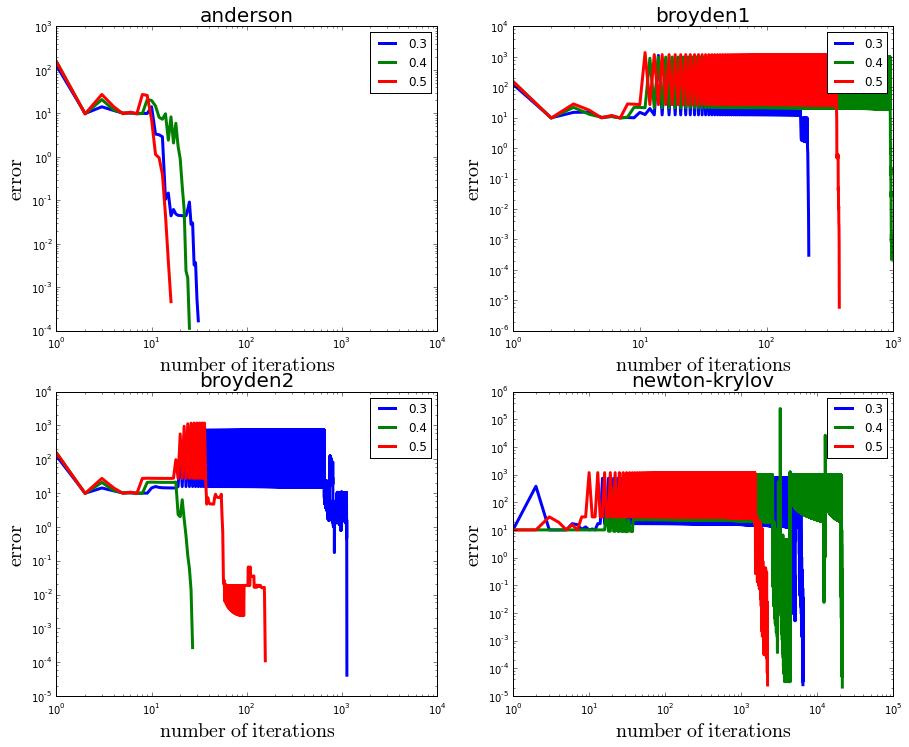

In [30]:
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot(221)
for i in range(3):
    num_iter = np.arange(0, len(error_dict['anderson'][i+3]), 1)
    ax1.plot(num_iter, error_dict['anderson'][i+3], lw=3, label=str(V_G_range[i+3]))
plt.legend(loc='upper right')
plt.title('anderson', fontsize=20)
plt.ylabel('$\mathrm{error}$', fontsize=20)
plt.xlabel('$\mathrm{number \ of \ iterations}$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10000)
plt.ylim(0.0001, 1000)

ax2 = plt.subplot(222)
for i in range(3):
    num_iter = np.arange(0, len(error_dict['broyden1'][i+3]), 1)
    ax2.plot(num_iter, error_dict['broyden1'][i+3], lw=3, label=str(V_G_range[i+3]))
plt.legend(loc='upper right')
plt.title('broyden1', fontsize=20)
plt.ylabel('$\mathrm{error}$', fontsize=20)
plt.xlabel('$\mathrm{number \ of \ iterations}$', fontsize=20)
plt.xscale('log')
plt.yscale('log')

ax3 = plt.subplot(223)
for i in range(3):
    num_iter = np.arange(0, len(error_dict['broyden2'][i+3]), 1)
    ax3.plot(num_iter, error_dict['broyden2'][i+3], lw=3, label=str(V_G_range[i+3]))
plt.legend(loc='upper right')
plt.title('broyden2', fontsize=20)
plt.ylabel('$\mathrm{error}$', fontsize=20)
plt.xlabel('$\mathrm{number \ of \ iterations}$', fontsize=20)
plt.xscale('log')
plt.yscale('log')

ax4 = plt.subplot(224)
for i in range(3):
    num_iter = np.arange(0, len(error_store[i+3]), 1)
    ax4.plot(num_iter, error_store[i+3], lw=3, label=str(V_G_range[i+3]))
plt.legend(loc='upper right')
plt.title('newton-krylov', fontsize=20)
plt.ylabel('$\mathrm{error}$', fontsize=20)
plt.xlabel('$\mathrm{number \ of \ iterations}$', fontsize=20)
plt.yscale('log')
plt.xscale('log')

plt.show()

In [34]:
with open("data_solver_benchmark.p", 'wb') as fp:
    pickle.dump(error_dict, fp)
    pickle.dump(V_G_range, fp)